# Process & Visualize ROI

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
sns.set()
from skimage import io

import processROI

## Tests

### test_get_masks

In [2]:
maskPattern = (
        "data/190603/aligned/" +
        "03_masks/*.bmp"
    )
masks = processROI.get_masks(maskPattern)
assert len(masks) == 57
assert all([x.shape == (512, 512) for x in masks])
assert np.sum(masks[0]) == 223
assert np.sum(masks[9]) == 163

### test_open_TIFF_stack

In [3]:
tiffsPattern = (
    "data/190603/aligned/" +
    "HN1953_190603_field1_00003_0000*.tif"
)
import glob
stack = processROI.open_TIFF_stack(tiffsPattern)
print(stack.shape)

(11679, 512, 512)


### test_cut_to_averages

In [4]:
timeseries = io.imread(
    "/Users/jonathanshor/Git/rinberg-rotation/data/190603/aligned/" +
    "HN1953_190603_field1_00003_00001.tif"
)

ROIaverages = processROI.cut_to_averages(timeseries, masks)
assert np.all(ROIaverages != 0)
assert round(ROIaverages[0, 0]) == 122
assert round(ROIaverages[200, 0]) == 155
assert round(ROIaverages[400, 3]) == 82

## Process & Show
Using only a single example session

In [5]:
dF_F = processROI.process(tiffsPattern, maskPattern)
print(f"dF_F.shape: {dF_F.shape}")

dF_F.shape: (11679, 57)


In [6]:
# for i_ROI in range(dF_F.shape[1]):
#     plt.plot(dF_F[:,i_ROI])
# plt.plot(ROIaverages[:,2])

# plt.plot(dF_F[:,2] * np.mean(ROIaverages[:,2]))
figDims = (15,3)
sns.set(rc={'figure.figsize':figDims})

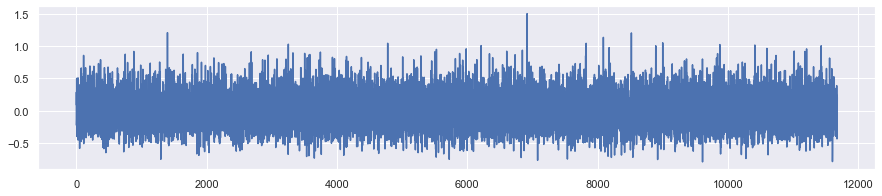

In [7]:
plt.plot(dF_F[:,1])

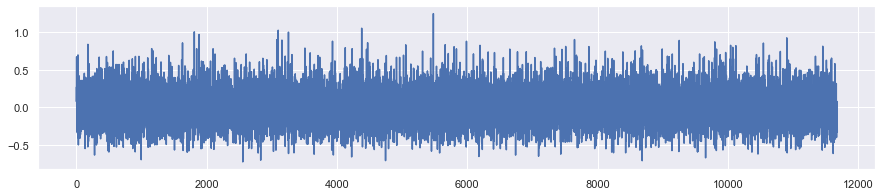

In [8]:
plt.plot(dF_F[:,2])

## Trial Averages

In [9]:
h5Filename = (
    "data/190603/" +
    "1953_1_04_D2019_6_3T12_29_13_odor.h5"
)
trialsMeta = processROI.get_trials_metadata(h5Filename)
timelocks = trialsMeta['inh_onset']
preWindow = 500
postWindow = 1500

In [10]:
import pandas as pd
# 3 blocks, each block: 1: blank, 2-8: 100A -> 0A, 9-15: 0A -> 100A. A and B always complement
blockTemplate = {'100% A, 0% B': [2, 15],
        '90% A, 10% B': [3, 14],
        '75% A, 25% B': [4, 13],
        '50% A, 50% B': [5, 12],
        '25% A, 75% B': [6, 11],
        '10% A, 90% B': [7, 10],
        '0% A, 100% B': [8, 9],}
trialGroups = {key: (np.tile(value, (3,1)) + (np.arange(3) * 15).reshape(3,1)).flatten() for key, value in blockTemplate.items()}
trialGroups = pd.DataFrame(data=trialGroups)
print(trialGroups)

   100% A, 0% B  90% A, 10% B  75% A, 25% B  50% A, 50% B  25% A, 75% B  \
0             2             3             4             5             6   
1            15            14            13            12            11   
2            17            18            19            20            21   
3            30            29            28            27            26   
4            32            33            34            35            36   
5            45            44            43            42            41   

   10% A, 90% B  0% A, 100% B  
0             7             8  
1            10             9  
2            22            23  
3            25            24  
4            37            38  
5            40            39  


In [11]:
trialPreTimelocks = pd.DataFrame()
trialPostTimelocks = pd.DataFrame()
trialTimelocks = pd.DataFrame()
for key in trialGroups:
#     print(timelocks.iloc[trialGroups[key] - 1])
    trialPreTimelocks[key] = timelocks.iloc[trialGroups[key] - 1].values - preWindow
    trialPostTimelocks[key] = timelocks.iloc[trialGroups[key] - 1].values + postWindow
    trialTimelocks[key] = timelocks.iloc[trialGroups[key] - 1].values
print(trialPreTimelocks)
print(trialTimelocks)
print(trialPostTimelocks)

   100% A, 0% B  90% A, 10% B  75% A, 25% B  50% A, 50% B  25% A, 75% B  \
0       2223344       2231862       2240059       2249221       2258588   
1       2340976       2332315       2324055       2315031       2304867   
2       2359564       2368786       2378415       2387439       2396560   
3       2476162       2467544       2458996       2450550       2441246   
4       2494215       2504229       2512636       2520986       2529236   
5       2612434       2602455       2593169       2583771       2574968   

   10% A, 90% B  0% A, 100% B  
0       2267569       2277534  
1       2295438       2286034  
2       2406089       2415096  
3       2432828       2424407  
4       2539131       2548498  
5       2566358       2558218  
   100% A, 0% B  90% A, 10% B  75% A, 25% B  50% A, 50% B  25% A, 75% B  \
0       2223844       2232362       2240559       2249721       2259088   
1       2341476       2332815       2324555       2315531       2305367   
2       2360064       236

In [37]:
key = "0% A, 100% B"
preFrames = processROI.frame_from_timestamp(h5Filename,trialPreTimelocks[key])
lockFrames = processROI.frame_from_timestamp(h5Filename, trialTimelocks[key])
postFrames = processROI.frame_from_timestamp(h5Filename,trialPostTimelocks[key])

In [38]:
print([y-x for x, y in zip(preFrames, lockFrames)])

[15, 15, 14, 15, 15, 15]


In [39]:
preWindows = [slice(pre,lock) for pre,lock in zip(preFrames, lockFrames)]
print(preWindows)

[slice(1606, 1621, None), slice(1860, 1875, None), slice(5724, 5738, None), slice(6002, 6017, None), slice(9717, 9732, None), slice(10008, 10023, None)]


In [40]:
preDataRaw = []

# dF_F[trialGroups[key], preWindows]
for i_slice, slic in enumerate(preWindows):
    preDataRaw.append(dF_F[slic, trialGroups[key][i_slice] - 1])
maxPre = max([len(x) for x in preDataRaw])
preDataAll = np.zeros((len(preWindows), maxPre))
for i_data, data in enumerate(preDataRaw):
    preDataAll[i_data, maxPre - len(preDataRaw[i_data]):] = preDataRaw[i_data]
preData = np.mean(preDataAll, axis=0)
print(preData)

[-0.0197077  -0.05604281  0.03237168 -0.06056043  0.14025737  0.25481823
  0.12131551  0.29087877  0.06024045  0.03455993  0.20886685  0.01226828
  0.07233978 -0.13243601 -0.07107097]


In [41]:
postWindows = [slice(lock,post) for lock,post in zip(lockFrames, postFrames)]
print(postWindows)

[slice(1621, 1666, None), slice(1875, 1920, None), slice(5738, 5783, None), slice(6017, 6062, None), slice(9732, 9777, None), slice(10023, 10068, None)]


In [42]:
postDataRaw = []

# dF_F[trialGroups[key], preWindows]
for i_slice, slic in enumerate(postWindows):
    postDataRaw.append(dF_F[slic, trialGroups[key][i_slice] - 1])
maxPost = max([len(x) for x in postDataRaw])
postDataAll = np.zeros((len(postWindows), maxPost))
for i_data, data in enumerate(postDataRaw):
    postDataAll[i_data, :maxPost + len(preDataRaw[i_data])] = postDataRaw[i_data]
postData = np.mean(postDataAll, axis=0)
print(postData)

[-0.06646762 -0.00443115  0.11253528 -0.07514222 -0.04376873  0.20284032
 -0.04063914  0.03005746 -0.04911272 -0.15398541  0.09015012  0.18576363
 -0.14664921  0.17620916 -0.00263377 -0.0909653  -0.09268798 -0.0461664
 -0.14465968 -0.07739882  0.01786084  0.11883716 -0.13988718 -0.04738507
 -0.12680866 -0.01284063  0.15877426  0.04039382 -0.16951429 -0.01050516
  0.01930195  0.00306531 -0.02050442  0.00250469 -0.05123942  0.0782957
  0.04058327 -0.05334796 -0.1426635   0.02170436 -0.01433053 -0.13654245
 -0.22637663 -0.08534299  0.05119397]


In [45]:
lockOffset = range(-len(preData), len(postData))
print(list(lockOffset))

[-15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]


Text(0.5, 1.0, '6 replicants')

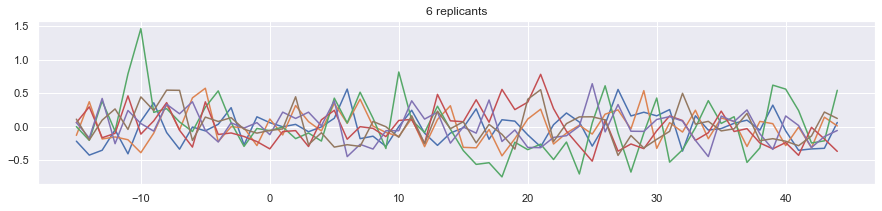

In [48]:
plt.plot(lockOffset, np.concatenate((preDataAll, postDataAll), axis=1).T)
plt.title("6 replicants")

Text(0.5, 1.0, 'Cross-trial Mean')

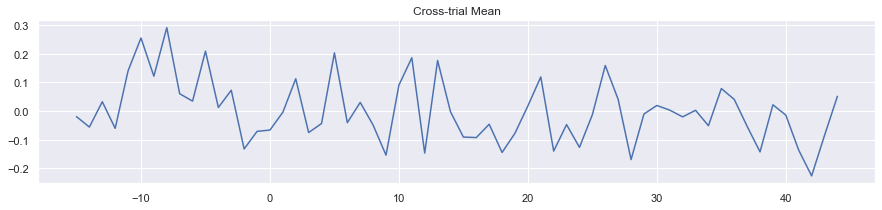

In [49]:
plt.plot(lockOffset,np.concatenate((preData, postData), axis=0))
plt.title("Cross-trial Mean")